<p align="left">
  <img src="./logo_UTN.svg" />
</p>


# **Teoría de Circuitos II - R4001 - 2023**
## Trabajo Semanal 3
### Autor: Bruno Glecer

# Consigna

La tarea semanal consiste en diseñar un filtro pasabajos que respete la siguiente plantilla.

<div>
    <img src="plantilla.png" width="400"/>
</div>

Donde los parametros son los siguientes:
- $\large\alpha_{max} = 1\mathrm{dB}$
- $\large\alpha_{min} = 12\mathrm{dB}$
- $\large f_{p} = 1500\mathrm{Hz}$
- $\large f_{s} = 3000\mathrm{Hz}$

Se piden las siguientes consignas:

1. Obtener la transferencia para máxima planicidad en la banda de paso utilizando los conceptos de partes de función. Recordar que:  $|T\left(j\omega\right)|^2 = T\left(j\omega\right) \cdot T\left(−j\omega\right) = T\left(s\right) \cdot T \left(−s \right)|_{s=j\omega}$
2. Obtener el diagrama de polos y ceros, y un bosquejo de la respuesta en frecuencia.
3. Implementar el circuito normalizado con estructuras pasivas separadas mediante buffers.
4. Obtenga el circuito que cumpla con la plantilla requerida si dispone de capacitores de 100nf.
5. Proponga una red que se comporte igual a la hallada en 4) pero con resistores, capacitores y opamps.
6. (TODO) (Bonus)  Proponer un planteo alternativo a 1) usando la $\omega_{Butter}$ (ver Schaumann 6.4)
7. (Bonus)  Simulación numérica y circuital.

In [1]:
from sympy import solve, symbols, Eq


#Variables conocidas
R1, R2, R3, R4, C, s = symbols("R1 R2 R3 R4 C s")

#Variables desconocidas
H, Vi, Vo, I1, I2, I3, I4, I5, I6, Va, Vb = symbols("H Vi Vo I1 I2 I3 I4 I5 I6 Va Vb")
unknowns = [H, Vi, Vo, I1, I2, I3, I4, I5, I6, Va, Vb]

equations = []

#Ecuaciones de mallas
equations.append(Eq(Vi, I6*R1))
equations.append(Eq(-Va, R2*I1))
equations.append(Eq(-Va, I2*1/(C*s)))
equations.append(Eq(Va, I3*R3))
equations.append(Eq(-Vb, I3*1/(C*s)))
equations.append(Eq(Vb, R4*I4))
equations.append(Eq(-Vo, I4*R4))
equations.append(Eq(Vo, R3*I5))

#Ecuaciones de nodos
equations.append(Eq(I6 + I5, I1 + I2))

#Relacion de H con tensiones
equations.append(Eq(H, Vo/Vi))

#Resolver
sol_H = solve(equations, unknowns, dict=True)[0][H]


sol_H

-R2*R3/(R1*(C**2*R2*R3**2*s**2 + C*R3**2*s + R2))

# 1. Deducción de la transferencia

Los filtros de máxima planicidad son aquellos que tienen una transferencia lo mas uniforme posible en la pasabanda. Para lograr esto, lo que se busca es que la transferencia tenga la mayor cantidad de derivadas iguales a cero en $\omega = 0$. Esto nos lleva a que la **potencia** de la transferencia tenga la siguiente forma normalizada en frecuencia:

$$|T(j \omega)|^2 = \frac{1}{1 + \varepsilon^2 \omega^{2n}} $$

Este desarrollo se encuentra mas detallado en Schaumann 6.2

Para este punto vamos a trabajar con la frecuencia normalizada por $\omega_p = 2 \pi f_p$, es decir, estaremos trabajando con las frecuencias de paso y corte:

$$\omega_p = 1$$
$$\omega_s = \frac{3000Hz}{1500Hz} = 2$$


A su vez, vamos a definir la atenuacion del filtro como:

$$  \alpha(\omega) = -T_{\mathrm{dB}}(j \omega) =  - 20 \log \left(|T(j \omega) | \right) = -10 \log \left( |T(j \omega) |^2 \right) $$
$$  \alpha(\omega) = -10 \log \left( \frac{1}{1 + \varepsilon^2 \omega^{2n}} \right) = 10 \log \left(1 + \varepsilon^2 \omega^{2n} \right)$$

La funcion de atenuacion, al ser monotonamente creciente, alcanza con que se cumplan las siguientes condiciones para que se respeta la plantilla entera:

$$
\begin{align}
 \alpha(\omega_p)     &\le \alpha_{max} \label{eq1}\tag{1} \\
     \alpha(\omega_s) &\ge \alpha_{min} \label{eq2}\tag{2}
\end{align}
$$

Usando (\ref{eq1}) y trabajando con la frecuencia normalizada como se mencionó antes:

$$ \alpha(\omega_p) = \alpha(1) = 10 \log \left(1 + \varepsilon^2 \right) \le \alpha_{max}$$

Resolviendo esta inecuacón obtenemos:

$$ \large \varepsilon \le \sqrt{{10}^{\frac{\alpha_{max}}{10}} - 1} \approx 0.5088$$

Para este diseño directamente tomaremos el caso borde de $\varepsilon = 0.5088$

Ahora podemos deducir de que orden debe ser el sistema para poder cumplir con la condicion impuesta por $\alpha_{min}$.

Usando el metodo visto en clase, esto lo podemos encontrar incrementando $n$ hasta llegar a un orden que haga que se cumpla la condición, de esta forma no hay necesidad de despejar (\ref{eq2}).

- $n=1 ~~~~~~~~~~~ \alpha(\omega_s) = 10 \log \left( 1 + \varepsilon^{2} \omega_s^{2n} \right) = 3.09\mathrm{dB} < \alpha_{min}$
- $n=2 ~~~~~~~~~~~ \alpha(\omega_s) = 10 \log \left( 1 + \varepsilon^{2} \omega_s^{2n} \right) = 7.11\mathrm{dB} < \alpha_{min}$
- $n=3 ~~~~~~~~~~~ \alpha(\omega_s) = 10 \log \left( 1 + \varepsilon^{2} \omega_s^{2n} \right) = 12.4\mathrm{dB} > \alpha_{min}$

Como se puede ver, el orden minimo que el filtro tiene que tener es de $n=3$

En este punto ya podemos decir que encontramos la potencia de la funcion de transferencia del filtro:

$$|T(j\omega)|^2 = \frac{1}{1 + \varepsilon^2 \omega^{6}}$$

Ahora falta hallar la transferencia $T(s)$

Para esto, comenzamos generalizando el argumento de la transferencia a la variable de frecuencia compleja $s$ y llevando los polinomios a su forma con coeficientes principales unitarios:

$$|T(s)|^2 = \frac{1}{1 + \varepsilon^2 \left({\frac{s}{j}}\right)^{6}} = \frac{1}{1 - \varepsilon^2 s^{6}} = \frac{\varepsilon^{-2}}{\varepsilon^{-2} - s^{6}}$$

Para encontrar $T(s)$ se usa el hecho de que la función de transferencia cumple la siguiente relacion: $|T(s)|^2 = T(s) \cdot T(-s) $. Pero hay mas de un una funcion $T(s)$ que nos puede dar $|T(s)|^2$, por esto debemos elegir cuidadosamente $T(s)$ para que sea la deseada.

Para visualizar mejor la situacion, abajo se presenta el diagrama de polos y ceros de $|T(s)|^2$

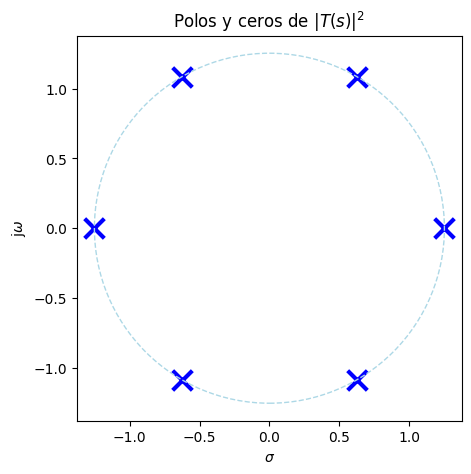

In [2]:

import numpy as np
import sympy.physics.control.lti as lti
from sympy.physics.control import pole_zero_numerical_data
from sympy.abc import s
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 5]

ax = plt.gca()
ax.set_box_aspect(1)

eps = 0.5088

TT = lti.TransferFunction(1, 1 - eps**2 * s**6, s)
poles = pole_zero_numerical_data(TT)[1]

plt.scatter(np.real(poles), np.imag(poles), color='b', marker='x', s=200, linewidths=3)
ax.add_patch(plt.Circle((0, 0), eps**(-1/3), color='lightblue', linestyle='--', fill=False))
ax.set_xlabel('$\sigma$')
ax.set_ylabel('j$\omega$')
ax.set_title('Polos y ceros de $|T(s)|^2$')
plt.show()

La tarea de encontrar la transferencia se reduce a encontrar la función $T(s)$ que cuando se multiplique por $T(-s)$ resulte en una función $\left(|T(s)|^2\right)$ que tenga los polos ubicados como se ven en la imagen superior.
 
La acción de invertir el argumento de una función compleja, hace que se espeje la imagen a través del origen. Sabiendo esto, por cada polo que ubiquemos en $T(s)$, estariamos ubicando dos polos en $|T(s)|^2$ (ya que es igual a $T(s) \cdot T(-s)$). Estariamos ubicando un polo en donde ubicamos el original, y otro espejado por el origen.

A continuación se muestran todas las formas de ubicar los polos

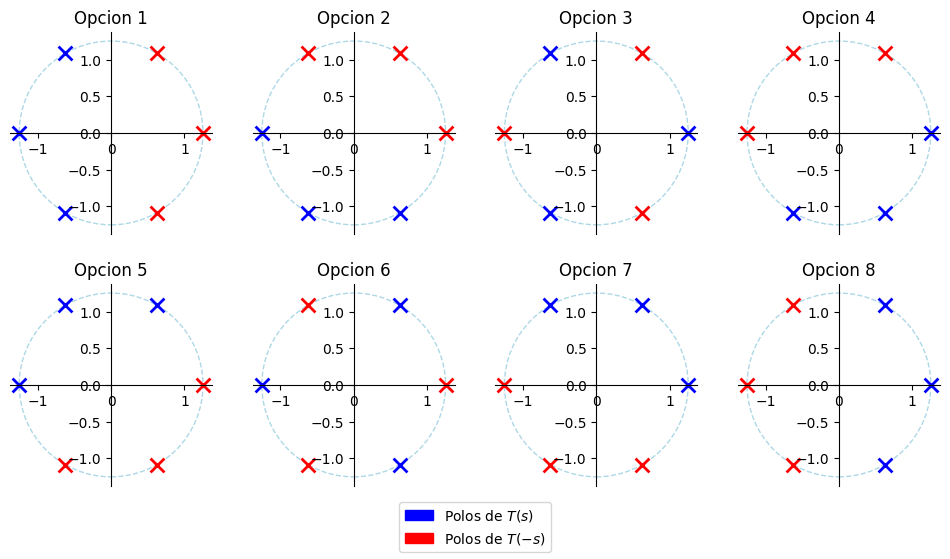

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]

fig, axs = plt.subplots(2, 4)


for i in range(8):
    ax = axs[i//4][i%4]
    T1_poles = ([poles[4]] if i&1 else [poles[0]]) + ([poles[5]] if i&2 else [poles[1]]) + ([poles[3]] if i&4 else [poles[2]])
    T2_poles = ([poles[4]] if ~i&1 else [poles[0]]) + ([poles[5]] if ~i&2 else [poles[1]]) + ([poles[3]] if ~i&4 else [poles[2]])

    ax.set_box_aspect(1)
    ax.add_patch(plt.Circle((0, 0), eps**(-1/3), color='lightblue', linestyle='--', fill=False))
    ax.scatter(np.real(T1_poles), np.imag(T1_poles), color='b', marker='x', s=100, linewidths=2)
    ax.scatter(np.real(T2_poles), np.imag(T2_poles), color='r', marker='x', s=100, linewidths=2)
    ax.set_title("Opcion " + str(i+1))
    ax.spines['left'].set_position(('data', 0.0))
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

fig.legend(handles=[mpatches.Patch(color='blue', label='Polos de $T(s)$'), mpatches.Patch(color='red', label='Polos de $T(-s)$')], loc='lower center')
plt.show()

Los gráficos de arriba muestran las ocho (o en terminos mas generales, las $2^n$) opciones que tenemos para elegir los polos de $T(s)$, pero no todas las opciones son validas, los polos siempre vienen de a pares conjugados para sistemas físicos, entonces nuestras unicas opciones son: 1, 3, 6 y 8.

Pero de estas, solo una opcion resulta en un filtro estable, la opcion 1, ya que todos los polos de $T(s)$ estan de la izquierda.

Ahora que sabemos que raices ubicar en $T(s)$ (las azules de la opción 1) podemos armar la función. Para esto, primero encontramos manualmente las raices de $|T(s)|^2$ usando SymPy

In [4]:
from sympy import solve, symbols, Eq, latex, root, simplify
from IPython.display import display, Math, Latex

sym_eps = symbols("\epsilon")

eq_poles_denom = Eq(0, 1 - sym_eps**2 * s**6)

sym_poles = solve(eq_poles_denom, s)

for i in range(6):
    display(Math(f'\large p_{i+1} = ' + (latex(simplify(sym_poles[i], ratio=1.3)))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Las raices que buscamos son $p_1$, $p_2$ y $p_5$. Con esta informacion ya podemos armar nuestra funcion de transferencia, nuevamente usando SymPy.
Hay que recordar resolver el numerador de $T(s)$, en este caso necesitamos que sea $\varepsilon^{-1}$ para que cuando se tome el modulo y se eleve al cuadrado, obtengamos el $\varepsilon^{-2}$ de $|T(s)|^2$

In [5]:
from sympy import simplify

T = (sym_eps**(-1))/((s - sym_poles[0])*(s - sym_poles[1])*(s - sym_poles[4]))

simplify(T, evaluate=0)

1/(\epsilon*(s**3 + 2*s**2*(\epsilon**(-2))**(1/6) + 2*s*(\epsilon**(-2))**(1/3) + sqrt(\epsilon**(-2))))

Asíllegamos a nuestra funció de transferencia (normalizada):


$$\large T(s) = \frac{\varepsilon^{-1}}{s^3 + s^2 2 \varepsilon^{-\frac{1}{3}} + s 2 \varepsilon^{-\frac{2}{3}} + \varepsilon^{-1}} $$

# 2. Diagramas

Utilizando la libreria de pytc2, podemos obtener los graficos de la función de transferencia facilmente

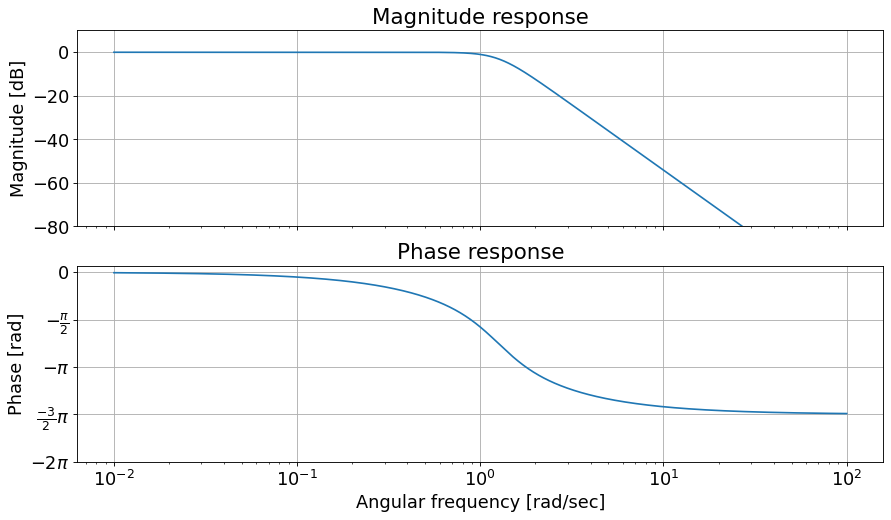

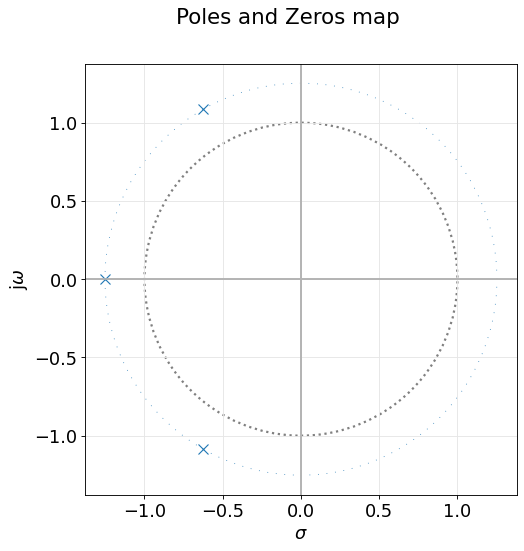

In [6]:
from pytc2.sistemas_lineales import bodePlot, pzmap, GroupDelay, analyze_sys
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal as sig

#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
plt.figure(1)
plt.close(1)

fig_sz_x = 13
fig_sz_y = 7
fig_dpi = 80 # dpi
fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_font_size})


#Configuracion del circuito
w0 = 1

#Funcion de transferencia
tf_num = np.array([eps**(-1)])
tf_den = np.array([1, 2*eps**(-1/3), 2*eps**(-2/3), eps**(-1)])
tf_H = sig.TransferFunction(tf_num, tf_den)

#Bode plot de la libreria pytc2
_, axes_hdl = bodePlot(tf_H)

plt.sca(axes_hdl[0])
plt.ylim([-80,10])

#Diagrama de polos y ceros de la libreria pytc2
pzmap(tf_H)

plt.show()

Como era de esperar, podemos ver la planicidad que tiene el filtro hasta $\omega = 1$ donde comienza a atenuar con un rolloff de $-60 ~ \mathrm{dB/dec}$. Esta circunferencia tiene radio $\varepsilon^{-1/3}$
Tambien se pueden observar los polos ubicados en una circunferencia del plano complejo.

# 3. Circuito normalizado

Como es un circuito de tercer orden, lo decido implementar usando una etapa de segundo orden y otra de primer orden.

La etapa de segundo orden va a ser la que introduce los polos complejos conjugados en el sistema, y dejo que la de primer orden introduzca el polo real.

Para esto tengo que separar la transferencia en dos terminos. Una que corresponda a un sistema de primer orden, y otra que corresponda a un sistema de segundo orden.

$$\large T(s) = \frac{\varepsilon^{-1}}{s^3 + s^2 2 \varepsilon^{-1/3} + s 2 \varepsilon^{-2/3} + \varepsilon^{-1}} 
= \frac{\varepsilon^{-1/3}}{s + {\varepsilon}^{-1/3}} \cdot \frac{\varepsilon^{-2/3}}{ s^2 + s \varepsilon^{-1/3} + \varepsilon^{-2/3} }$$

Tambien es importante asegurarse de que el numerador quede bien distribuido haciendo que la ganancia en $s=0$ de cada etapa sea 1.

Estudiando las funciones de transferencias genericas para filtros de orden uno y dos se puede ver que:

- El primer termino correspone a un filtro pasa bajos de primer orden con $\large \omega_0 = \varepsilon^{-1/3} $

- El segundo termino corresponde a un filtro pasa bajos de segudo orden de caracteristicas $\large \omega_0 = \varepsilon^{-1/3}$ y $Q = 1$

## Circuito de primer orden

Para implementar la primera etapa, decido usar un filtro pasabajos RC, ya que es el mas sencillo que cumple con los requisitos. La red del filtro normalizada tiene la siguiente forma:


<div>
    <img src="etapa_1_norm.png" width="400"/>
</div>

Desnormalizando con la frecuencia de corte $\omega_0 = \varepsilon^{-1/3}$ obtenemos la siguiente red


<div>
    <img src="etapa_1.png" width="400"/>
</div>


## Circuito de segundo orden

Para implementar la segunda etapa, usamos un filtro pasabajos RLC de segundo orden, su red normalizada es la siguiente:


<div>
    <img src="etapa_2_norm.png" width="400"/>
</div>

Desnormalizando con la frecuencia de corte $\omega_0 = \varepsilon^{-1/3}$ obtenemos la siguiente red


<div>
    <img src="etapa_2.png" width="400"/>
</div>

## Red normalizada final


Conectando ambos filtros mediante un seguidor, nos permite que el segundo filtro no afecte la transferencia del primero.
En este paso tambien remplazamos $\varepsilon$ por su valor numerico.
Y asi llegamos al circuito normalizado con transferencia de máxima planicidad.

<div>
    <img src="circuito_norm.png" width="800"/>
</div> 


#  4. Circuito con valores de capacitores dados

Si para armar el circuito solo disponemos de capacitores de $100\mathrm{nF}$, tendriamos que ajustar el resto de los componentes acordemente.

El valor de $C_1$ desnormalizado es: $C_1 = \large \frac{0.798}{\omega_p R_1}$, ya que habiamos normalizado por $\omega_p$ y el filtro RLC estaba normalizado por $R_1$. Como $\omega_p$ y $C_1$ son conocidos, podemos despejar $R_1$ para obtener:

$$R_1 = 847 \Omega$$

Lo mismo ocurre con $R_2$ y $C_2$:

$$R_2 = 847 \Omega$$

Para desnormalizar $L_1$ simplemente aplicamos su ecuacion de desnomralizacion:

$$L_1 = \frac{0.798}{\omega_p} R_2 = 71.7 \mathrm{mH} $$

Con todos los componentes calculados, podemos redibujar el circuito:

<div>
    <img src="circuito_100nF.png" width="800"/>
</div> 


# 5. Circuito sin el uso de inductores

Con la restricción de no usar inductores, tenemos que descartar el filtro pasa bajos RLC por un filtro de segundo orden que solo haga uso de capacitores, resistencias y opamps. Un buen candidato para esta aplicación es la topologia Akerberg-Mossberg que se muestra a continuacion


<div>
    <img src="mossberg.png" width="800"/>
</div> 


Queremos que tenga la misma respuesta que el RLC del punto anterior. Los calculos para los valores desnomalizados son muy similares.

Al igual que antes, queremos que tenga los parametros: $\omega_0 = \varepsilon^{-1/3}$ y $Q = 1$.

Esto nos lleva al circuito:

<div>
    <img src="mossberg_norm.png" width="800"/>
</div> 

Decidí tomar como salida ese punto porque la salida tradicional tiene una ganancia negativa, y para obtener el comportamiento identico al punto anterior, requeriria un inversor. De esta forma no se requiere ningun componente extra. Al ser un nodo de baja impedencia controlado por un opamp, la segunda etapa no afectará la transferencia de la primera.

Finalmente, le agregamos la etapa de primer orden a la salida. Podemos reusar el diseño del punto anterior para esto.
Tambien desnormalizamos completamente el circuito al igual que como hicimos en el punto anterior.



<div>
    <img src="mossberg_denorm.png" width="800"/>
</div> 

# 7. Simulación Numerica

Las simulaciones numericas de los circuitos fueron realizados en LTSpice.
Se usó el instructivo .meas para obtener mediciones de la ganancia en los puntos de interes de $1500\mathrm{Hz}$ y $3000\mathrm{Hz}$


## Simulacion de circuito con RLC

### Circuito de entrada

<div>
    <img src="sim1_schem.png" width="800"/>
</div> 

### Resultados

<div>
    <img src="sim1_plot.png" width="800"/>
</div> 


- **Ganancia @1500Hz = -0.98dB**
- **Ganancia @3000Hz = -12.4dB**


## Simulacion de circuito con Akerberg-Mossberg

### Circuito de entrada

<div>
    <img src="sim2_schem.png" width="800"/>
</div> 

### Resultados

<div>
    <img src="sim2_plot.png" width="800"/>
</div> 


- **Ganancia @1500Hz = -0.99dB**
- **Ganancia @3000Hz = -12.4dB**


## Conculsiones


Ambas simulaciones dan resultados practicamente identicos, y las ganancias en $f_p$ y $f_s$ dan casi igual a los valores calculados al principio del punto 1.

